# For this EDA we use github.com/smartbugs/smartbugs-curated

In [1]:
from pathlib import Path
import json
import re

import pandas as pd
import matplotlib.pyplot as plt

# Point this to the root of the cloned repo
# If you run the notebook from inside the repo, use Path(".")
REPO_ROOT = Path("smartbugs-curated").resolve()

vuln_json_path = REPO_ROOT / "vulnerabilities.json"
dataset_root = REPO_ROOT / "dataset"

print("Repo root:", REPO_ROOT)
print("vulnerabilities.json exists:", vuln_json_path.exists())
print("dataset/ exists:", dataset_root.exists())


Repo root: /Users/maksimg/Uni/project/smartbugs-curated
vulnerabilities.json exists: True
dataset/ exists: True


In [12]:

# Load raw JSON
with open(vuln_json_path, "r", encoding="utf-8") as f:
    vuln_raw = json.load(f)

print("Type:", type(vuln_raw))
print("Number of contracts in vulnerabilities.json:", len(vuln_raw))

# Quick peek at first entry
vuln_raw[0]


Type: <class 'list'>
Number of contracts in vulnerabilities.json: 143


{'name': 'FibonacciBalance.sol',
 'path': 'dataset/access_control/FibonacciBalance.sol',
 'pragma': '0.4.22',
 'source': 'https://github.com/sigp/solidity-security-blog',
 'vulnerabilities': [{'lines': [31], 'category': 'access_control'},
  {'lines': [38], 'category': 'access_control'}]}

In [13]:
def build_contracts_df(vuln_raw):
    rows = []
    for c in vuln_raw:
        vulns = c.get("vulnerabilities", []) or []
        path = c.get("path", "")
        
        # DASP-like category is encoded as the last directory in dataset/<cat>/<file>.sol
        category = Path(path).parent.name if path else None
        
        n_vulns = len(vulns)
        n_vuln_lines = sum(len(v.get("lines") or []) for v in vulns)
        
        rows.append(
            {
                "name": c.get("name"),
                "rel_path": path,
                "category_dasp": category,
                "pragma": c.get("pragma"),
                "source": c.get("source"),
                "n_vulns": n_vulns,
                "n_vuln_lines": n_vuln_lines,
            }
        )
    return pd.DataFrame(rows)

contracts_df = build_contracts_df(vuln_raw)
contracts_df.head()


,name,rel_path,category_dasp,pragma,source,n_vulns,n_vuln_lines
0,FibonacciBalance.sol,dataset/access_control/FibonacciBalance.sol,access_control,0.4.22,https://github.com/sigp/solidity-security-blog,2,2
1,arbitrary_location_write_simple.sol,dataset/access_control/arbitrary_location_writ...,access_control,0.4.25,https://smartcontractsecurity.github.io/SWC-re...,1,1
2,incorrect_constructor_name1.sol,dataset/access_control/incorrect_constructor_n...,access_control,0.4.24,https://github.com/trailofbits/not-so-smart-co...,1,1
3,incorrect_constructor_name2.sol,dataset/access_control/incorrect_constructor_n...,access_control,0.4.24,https://smartcontractsecurity.github.io/SWC-re...,1,1
4,incorrect_constructor_name3.sol,dataset/access_control/incorrect_constructor_n...,access_control,0.4.24,https://smartcontractsecurity.github.io/SWC-re...,1,1


In [14]:
def build_vulns_df(vuln_raw):
    rows = []
    for c in vuln_raw:
        path = c.get("path")
        name = c.get("name")
        pragma = c.get("pragma")
        source = c.get("source")
        
        for v in c.get("vulnerabilities", []) or []:
            rows.append(
                {
                    "contract_name": name,
                    "rel_path": path,
                    "category_dasp": v.get("category"),
                    "lines": v.get("lines"),
                    "n_lines": len(v.get("lines") or []),
                    "pragma": pragma,
                    "source": source,
                }
            )
    return pd.DataFrame(rows)

vulns_df = build_vulns_df(vuln_raw)
vulns_df.head()


,contract_name,rel_path,category_dasp,lines,n_lines,pragma,source
0,FibonacciBalance.sol,dataset/access_control/FibonacciBalance.sol,access_control,[31],1,0.4.22,https://github.com/sigp/solidity-security-blog
1,FibonacciBalance.sol,dataset/access_control/FibonacciBalance.sol,access_control,[38],1,0.4.22,https://github.com/sigp/solidity-security-blog
2,arbitrary_location_write_simple.sol,dataset/access_control/arbitrary_location_writ...,access_control,[27],1,0.4.25,https://smartcontractsecurity.github.io/SWC-re...
3,incorrect_constructor_name1.sol,dataset/access_control/incorrect_constructor_n...,access_control,[20],1,0.4.24,https://github.com/trailofbits/not-so-smart-co...
4,incorrect_constructor_name2.sol,dataset/access_control/incorrect_constructor_n...,access_control,[18],1,0.4.24,https://smartcontractsecurity.github.io/SWC-re...


In [15]:
n_contracts = len(contracts_df)
n_vulns = len(vulns_df)

print(f"Contracts: {n_contracts}")
print(f"Vulnerability records: {n_vulns}\n")

print("Vulnerabilities per contract (min/median/max):")
print(contracts_df["n_vulns"].describe()[["min", "50%", "max"]], "\n")

print("Vulnerable lines per contract (min/median/max):")
print(contracts_df["n_vuln_lines"].describe()[["min", "50%", "max"]])


Contracts: 143
Vulnerability records: 207

Vulnerabilities per contract (min/median/max):
min     1.0
50%     1.0
max    12.0
Name: n_vulns, dtype: float64 

Vulnerable lines per contract (min/median/max):
min     1.0
50%     1.0
max    12.0
Name: n_vuln_lines, dtype: float64


In [16]:
cats_summary = (
    vulns_df.groupby("category_dasp")
    .agg(
        n_contracts=("contract_name", "nunique"),
        n_vulns=("contract_name", "size"),
        avg_lines_per_vuln=("n_lines", "mean"),
    )
    .sort_values("n_vulns", ascending=False)
)

cats_summary


,n_contracts,n_vulns,avg_lines_per_vuln
category_dasp,,,
unchecked_low_level_calls,52,75,1.000000
reentrancy,31,32,1.000000
bad_randomness,8,31,1.096774
arithmetic,15,23,1.000000
access_control,18,21,1.142857
denial_of_service,6,7,2.000000
front_running,4,7,1.000000
time_manipulation,5,7,1.000000
other,3,3,1.666667


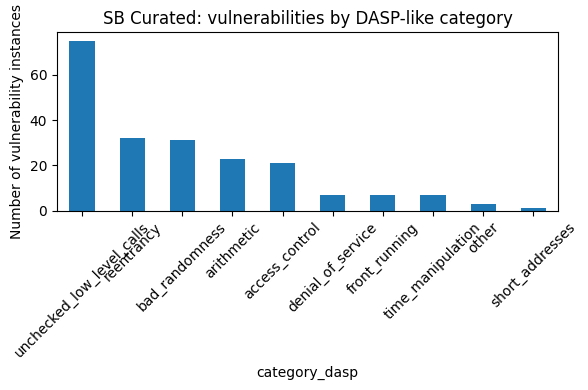

In [17]:
ax = cats_summary["n_vulns"].plot(
    kind="bar",
    figsize=(6, 4),
    rot=45,
)
ax.set_ylabel("Number of vulnerability instances")
ax.set_title("SB Curated: vulnerabilities by DASP-like category")
plt.tight_layout()
plt.show()


In [18]:
def extract_version_tag(pragma_str):
    """Return major.minor from 'pragma solidity' constraint, e.g. 0.4.25 => 0.4"""
    if not isinstance(pragma_str, str):
        return None
    m = re.search(r"(\d+\.\d+)", pragma_str)
    return m.group(1) if m else None

contracts_df["pragma_version"] = contracts_df["pragma"].map(extract_version_tag)

pragma_counts = contracts_df["pragma_version"].value_counts().sort_index()
pragma_counts


pragma_version
0.4    142
0.5      1
Name: count, dtype: int64

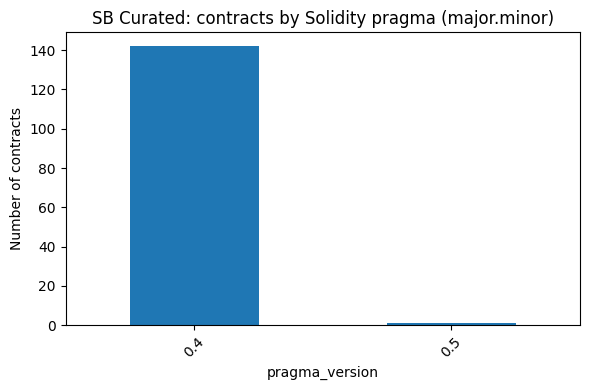

In [19]:
ax = pragma_counts.plot(kind="bar", figsize=(6, 4), rot=45)
ax.set_ylabel("Number of contracts")
ax.set_title("SB Curated: contracts by Solidity pragma (major.minor)")
plt.tight_layout()
plt.show()


In [20]:
def extract_swc_codes(source_str):
    if not isinstance(source_str, str):
        return []
    return re.findall(r"SWC-\d+", source_str)

contracts_df["swc_codes"] = contracts_df["source"].map(extract_swc_codes)

# One row per (contract, SWC) pair
swc_df = (
    contracts_df.loc[contracts_df["swc_codes"].map(len) > 0]
    .explode("swc_codes")
    .rename(columns={"swc_codes": "swc"})
)

swc_df.head()


,name,rel_path,category_dasp,pragma,source,n_vulns,n_vuln_lines,pragma_version,swc
1,arbitrary_location_write_simple.sol,dataset/access_control/arbitrary_location_writ...,access_control,0.4.25,https://smartcontractsecurity.github.io/SWC-re...,1,1,0.4,SWC-124
3,incorrect_constructor_name2.sol,dataset/access_control/incorrect_constructor_n...,access_control,0.4.24,https://smartcontractsecurity.github.io/SWC-re...,1,1,0.4,SWC-118
4,incorrect_constructor_name3.sol,dataset/access_control/incorrect_constructor_n...,access_control,0.4.24,https://smartcontractsecurity.github.io/SWC-re...,1,1,0.4,SWC-118
5,mapping_write.sol,dataset/access_control/mapping_write.sol,access_control,0.4.24,https://smartcontractsecurity.github.io/SWC-re...,1,1,0.4,SWC-124
9,parity_wallet_bug_2.sol,dataset/access_control/parity_wallet_bug_2.sol,access_control,0.4.9,https://smartcontractsecurity.github.io/SWC-re...,2,2,0.4,SWC-106


In [21]:
swc_summary = (
    swc_df.groupby("swc")
    .agg(
        n_contracts=("name", "nunique"),
        categories=("category_dasp", lambda x: sorted(x.unique())),
    )
    .sort_values("n_contracts", ascending=False)
)

swc_summary.head(10)


,n_contracts,categories
swc,,
SWC-101,3,[arithmetic]
SWC-105,3,[access_control]
SWC-118,2,[access_control]
SWC-124,2,[access_control]
SWC-104,1,[unchecked_low_level_calls]
SWC-106,1,[access_control]
SWC-112,1,[access_control]


In [22]:
swc_cat_ct = pd.crosstab(swc_df["swc"], swc_df["category_dasp"])
swc_cat_ct.head()


category_dasp,access_control,arithmetic,unchecked_low_level_calls
swc,,,
SWC-101,0,3,0
SWC-104,0,0,1
SWC-105,3,0,0
SWC-106,1,0,0
SWC-112,1,0,0


In [23]:
def count_loc(path_str):
    if not isinstance(path_str, str):
        return None
    path = REPO_ROOT / path_str
    if not path.is_file():
        return None
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            return sum(1 for _ in f)
    except OSError:
        return None

contracts_df["loc"] = contracts_df["rel_path"].map(count_loc)

contracts_df["loc"].describe()


count     143.000000
mean      101.510490
std       234.744298
min        14.000000
25%        28.000000
50%        42.000000
75%        94.500000
max      2470.000000
Name: loc, dtype: float64

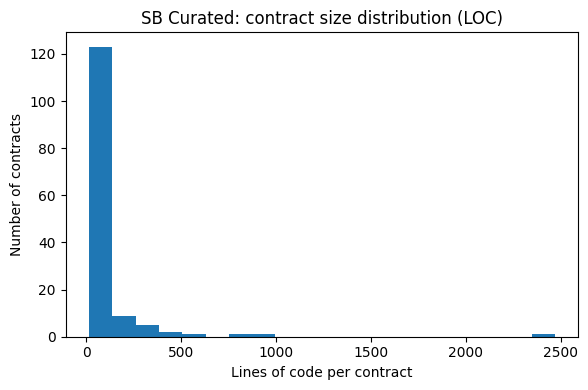

In [24]:
contracts_df["loc"].plot(kind="hist", bins=20, figsize=(6, 4))
plt.xlabel("Lines of code per contract")
plt.ylabel("Number of contracts")
plt.title("SB Curated: contract size distribution (LOC)")
plt.tight_layout()
plt.show()


In [25]:
out_dir = REPO_ROOT / "analysis_outputs"
out_dir.mkdir(exist_ok=True)

contracts_df.to_csv(out_dir / "sb_curated_contracts_summary.csv", index=False)
vulns_df.to_csv(out_dir / "sb_curated_vulns_flat.csv", index=False)
swc_cat_ct.to_csv(out_dir / "sb_curated_swc_vs_dasp_crosstab.csv")

print("Saved CSVs to:", out_dir)


Saved CSVs to: /Users/maksimg/Uni/project/smartbugs-curated/analysis_outputs
